# Import package 

In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from qm import generate_qua_script

#General os library 
import os
import time
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_exi_vac import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element

#Path for HQCPC7 
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function

#Path for HQC PC15 
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
#import AnFunc as an 
import scipy.io
from scipy import signal 
from scipy.optimize import curve_fit

In [2]:
def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["twoPhoton_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""
    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_time_of_flight(time_of_flight,config,qmm):
    """ Update the time_of_flight of the qm in the configuration file """
    config["elements"]["resonator"]["time_of_flight"]=time_of_flight
    
    qm=qmm.open_qm(config)
    
    return config, qm

# OPX configuration

In [3]:
#Octave & OPX configuration 


Saving_Path=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\\"
Cooldown_Date="2023_04_14"


opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave


qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)

octave_output_gain=-10

#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)  #RFOutputMode.trig_normal

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-04-27 18:52:40,192 - qm - INFO - Performing health check
2023-04-27 18:52:40,205 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-04-27 18:52:40,206 - qm - INFO - Health check passed


In [4]:
#Setting the gain
gain=-6
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

time_of_flight=24

config, qm=update_time_of_flight(time_of_flight,config,qmm)

pulse_amp=0.125
config,qm=update_pulse_amplitude(pulse_amp,config,qmm)


# Display parameter

In [5]:
print("LO of resonator : {} GHz".format(config['elements']['resonator']["mixInputs"]["lo_frequency"]/1e9))
print("IF of resonator : {} GHz".format(config['elements']['resonator']['intermediate_frequency']/1e9))
print("Time of flight of resonator : {} ns".format(config['elements']['resonator']['time_of_flight']))
print("Readout time resonator : {} ns".format(config["pulses"]["zero_pulse"]["length"]))
print("LO of fluxline: {} GHz".format(config['elements']['fluxline']["mixInputs"]["lo_frequency"]/1e9))
print("IF of fluxline : {} GHz".format(config['elements']['fluxline']['intermediate_frequency']/1e9))
print("Ramping time of fluxline : {} ns".format(config['elements']['fluxline']['hold_offset']))
print("Fluxline pulse time : {} ns".format(config["pulses"]["twoPhoton"]["length"]))
print("Fluxline amplitude : {} V".format(config["waveforms"]["twoPhoton_wf"]['sample']))

LO of resonator : 4.2 GHz
IF of resonator : 0.318 GHz
Time of flight of resonator : 24 ns
Readout time resonator : 2000 ns
LO of fluxline: 8.5 GHz
IF of fluxline : 0.1958 GHz
Ramping time of fluxline : {'duration': 5000} ns
Fluxline pulse time : 1000 ns
Fluxline amplitude : 0.125 V


# Testing the pump 

In [7]:
#Mixer Calibration 
#Calibration of the fluxline mixer 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-04-27 17:18:23,167 - qm - INFO - Flags: 
2023-04-27 17:18:23,168 - qm - INFO - Compiling program
2023-04-27 17:18:25,903 - qm - INFO - Sending pre-compiled program to QOP


In [3]:
# Testing the pump 
with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(0.1), 'fluxline')
        
job = qm.execute(TwoPhoton)


2023-04-21 16:14:28,195 - qm - INFO - Flags: 
2023-04-21 16:14:28,196 - qm - INFO - Sending program to QOP
2023-04-21 16:14:28,224 - qm - INFO - Executing program


In [92]:
#Two stop the two photon pumping 
job.halt()

NameError: name 'job' is not defined

# Sticky 

In [6]:
%matplotlib qt 

Readout_Len=10_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

twoPhoton_len=10_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)


amp_factor_array=np.array([0.6]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

amp_factor_high_array=np.array([1]) #Prefactor of the amplitude 
amp_factor_high=amp_factor_high_array[0]


n_repetition=10_000 #number of repetitions 

n_empty=100#number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be on low amp 
n_full=1_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

freqs_array=np.array([[ 0.191e9]]) # defines the ending frequency 
IF_right=196e6 # Starting frequency 


IF_pump=freqs_array[0,0] #select the frequency from the array 
pump_step=(IF_right-IF_pump)/n_empty


Offset_IF=0  

LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

wait_pump_step=16//4 #w aiting time after having played the pump
cooldown_time=5_000//4


with program() as IQ_blobs:

    n = declare(int)
    n_rep = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f_st= declare_stream()
    f = declare(int)
    n_rep_st=declare_stream()
    f_readout= declare(int)
    
    assign_variables_to_element("resonator", I,Q) 

    #Loop on the repetition 
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):
        
        
        #Play the first pulse of the sticky to set the pump frequency to define the amplitude 
        update_frequency("fluxline", IF_right)
        play("pumping"*amp(amp_factor_high), "fluxline") # bring the fluxline to the right 
        

        #loop over frequencies  
        with for_(f, IF_right, f>IF_pump, f-pump_step):

            assign(f_readout,LO_diff+f/2) #update the readout frequency 
            update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 

            #update the sticky 
            update_frequency("fluxline", f, keep_phase=True)
            play("pumping"*amp(0), "fluxline")
             
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            
        
            wait(wait_pump_step) #time that will be waited after playing the pump 
            
            save(I, I_st)
            save(Q, Q_st)
            save(f, f_st) 

        
        #ramp to zero, no so good 
        #ramp_to_zero("fluxline",16)
            
        
        #set the new amplitude 
        play("pumping"*amp(amp_factor-amp_factor_high), "fluxline") 

        # for i=0 to n_full 
        with for_(i, 0, i < n_full, i + 1):
            play("pumping" * amp(0), 'fluxline') 
            
            measure(
            "fake_readout",
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            
            save(I, I_st)
            save(Q, Q_st)
            
        
        #ramp to zero, no so good 
        ramp_to_zero("fluxline")
        
        wait(cooldown_time)
        
        save(n_rep, n_rep_st)

    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")
        n_rep_st.save("n_rep")
        f_st.save("f") #save the last frequency to make sure it is the desired one 

simulation = False    

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1'})
    
    
else : 
    
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():

        I, Q, n_rep = results.fetch_all()

        time_vec=I["timestamp"]
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q["value"], Readout_Len)
    

        #Plotting the average 
        if len(I)>n_runs:

            #Datas are capted continously and then transfer into a 2D matrix and averaged
            it=len(I)//n_runs
            I_2d=I[0:it*n_runs].reshape((it,n_runs))
            Q_2d=Q[0:it*n_runs].reshape((it,n_runs))
            norm_2d=np.sqrt(I_2d**2+Q_2d**2)

            plt.subplot(211)
            fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
            plt.cla()
            plt.plot(np.angle(I_2d[it-1,:]+1j*Q_2d[it-1,:]), ".", markersize=2)
            #plt.plot(time_vec[0:n_runs],I_2d[it-1,:],".",markersize=2)
            plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
            plt.xlabel("Nb points")
            plt.ylabel("phase")
            plt.pause(0.1)


            plt.subplot(212)
            av=np.mean(norm_2d,axis=0) 
            plt.subplot(313)
            plt.cla()
            plt.plot(time_vec[0:n_runs]*1e-9,av*1e3,".",markersize=2)
            plt.xlabel("time [s]")
            plt.ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

            
time=time_vec[0:n_runs]          
            
Data={}
Data[amp_factor]={}
Data[amp_factor][IF_pump]={}
Data[amp_factor][IF_pump]["value"]=av
Data[amp_factor][IF_pump]["time"]=time

2023-04-27 18:52:52,014 - qm - INFO - Flags: 
2023-04-27 18:52:52,014 - qm - INFO - Sending program to QOP
2023-04-27 18:52:52,480 - qm - INFO - Executing program
Execution stopped by user!


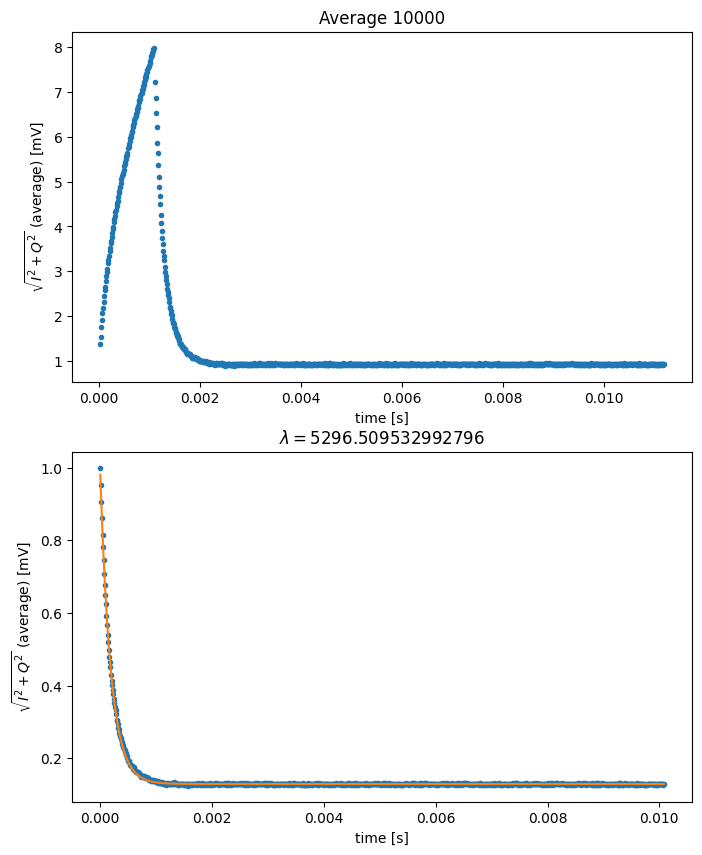

In [8]:
%matplotlib inline
number_avg=1
Processed_Data=an.Extract_vac_exc_gap(Data,amp_factor_array,freqs_array,n_empty,number_avg)

amp_factor=amp_factor_array[0]
freqs=freqs_array[0,:]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]

        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3,".")
        #ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("$\lambda= $"+str(gap))
        ax.plot(time_fit,av_fit,".")
        ax.plot(time_fit,y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")



    else:
        print("No fit")
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        
        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3)
        #ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time_fit,av_fit)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

# Single measurement 

Initial code with change in duration. However, doing like this saturates the memory, if you are trying to do relatively long measurement 

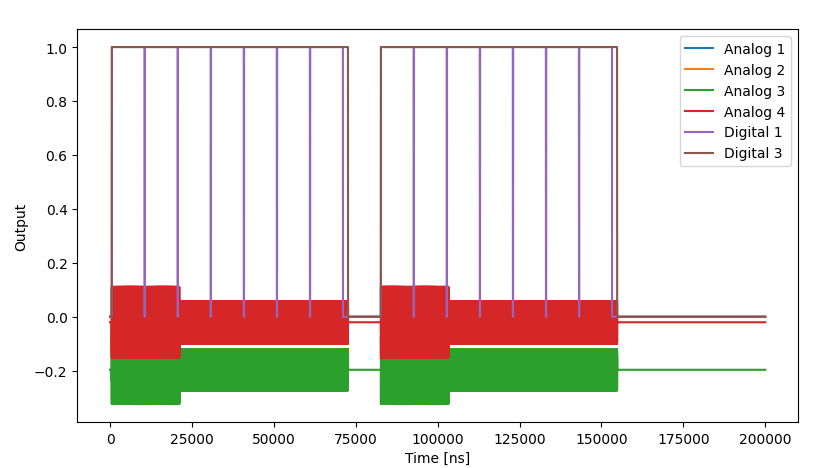

I think I can make this new measurement by implementing a sticky where the sticky with a high amplitude of 1 and then, we subtract to a low amplitude. As long as the high to low amplitude is down quickly enough, it should be good. But then, we need to move this to another folder 

In [10]:
%matplotlib qt

def First_jump_single_freq(Readout_Len, amp_factor, amp_factor_high, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm): 

    """ Take as input :

    Readout_Len : length of the readout that should be the same as defined in the configuration file. Here, it is necessary for the conversion to volt
    amp_factor : multiplication factor to the pump pulse amplitude 
    amp_factor_high : multiplication factor the pump pulse to bring the system to a high photon state 
    IF_pump : IF frequency of the pump -> necessary to update the config frequency 
    IF_resonator : If_frequency of the resonator -> necessary to update the config frequency 
    Offset_IF : general ofset if the IF of the resonator is not center 
    Pump_Delay ; time during which the pump low amplitude pump is on.  -- could be removed 
    n_repetition : number of times the program is repeated to get an average 
    n_empty : number of measurements when the pulse is low amplitude 
    n_full : number of measurements when the pulse is high amplitude 
    cooldown_time : waiting time between repetitions in nb of cycles 
    qm : quantum machine 
    """ 

    with program() as IQ_blobs:

        n = declare(int)
        n_rep = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()
        f = declare(int)
        n_rep_st=declare_stream()

        assign_variables_to_element("resonator", I,Q) 

        #Update the demodulation frequency 
        update_frequency("resonator",IF_resonator+Offset_IF) 
        update_frequency("fluxline",IF_pump)

        #Loop on the repetition 
        with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):

            #Loop on the repetition 
            with for_(i, 0, i < np.round((n_empty*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
                play("pumping" * amp(amp_factor_high), 'fluxline')  

            with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
                play("pumping" * amp(amp_factor), 'fluxline')  



            #Demodulation measurements 
            with for_(n, 0, n < n_runs, n + 1):

                #Demodulate n time 
                measure(
                    "fake_readout",
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                save(I, I_st)
                save(Q, Q_st)

            save(n_rep, n_rep_st)

            wait(cooldown_time) #wait the cooldown 

        with stream_processing():
            I_st.with_timestamps().save_all("I")
            Q_st.with_timestamps().save_all("Q")
            n_rep_st.save("n_rep")



    simulation = False     

    if simulation:
        simulation_config = SimulationConfig(
            duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
        )

        job = qmm.simulate(config, IQ_blobs, simulation_config)
        job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    else:

        job = qm.execute(IQ_blobs)
        results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")

        fig = plt.figure()
        interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

        while results.is_processing():

            I, Q, n_rep = results.fetch_all()

            time=I["timestamp"]
            I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse Readout_lEN 
            Q = u.demod2volts(Q["value"], Readout_Len)


            #Plotting the average 
            if len(I)>n_runs:

                #Datas are capted continously and then transfer into a 2D matrix and averaged
                it=len(I)//n_runs
                I_2d=I[0:it*n_runs].reshape((it,n_runs))
                Q_2d=Q[0:it*n_runs].reshape((it,n_runs))
                norm_2d=np.sqrt(I_2d**2+Q_2d**2)

                plt.subplot(211)
                fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
                plt.cla()
                plt.plot(np.angle(I_2d[it-1,:]+1j*Q_2d[it-1,:]), ".", markersize=2)
                plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
                plt.xlabel("Nb points")
                plt.ylabel("phase")
                plt.pause(0.1)


                plt.subplot(212)
                av=np.mean(norm_2d,axis=0) 
                plt.subplot(313)
                plt.cla()
                plt.plot(time[0:n_runs]*1e-9,av*1e3,".",markersize=2)
                plt.xlabel("time [s]")
                plt.ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")
                
                
    # Returns average signal and time in ns 
    return av,time[0:n_runs]

In [99]:
%matplotlib qt
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)


amp_factor_array=np.array([0.3]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

amp_factor_high_array=np.array([1.0]) #Prefactor of the amplitude 
amp_factor_high=amp_factor_high_array[0]


#Update the pump IF frequency 
freqs_array=np.array([[ 0.1950e9]]) # defines the IF of the pump  0.19565
IF_pump=freqs_array[0,0] #select the frequency from the array 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=100 #number of repetitions 

n_empty=5_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be on low amp 
n_full=30_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=1_000_000_000//4 #cooldown time before each repetition to go back to vacuum  #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

av,time=First_jump_single_freq(Readout_Len, amp_factor,amp_factor_high, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm)

Data={}
Data[amp_factor]={}
Data[amp_factor][IF_pump]={}
Data[amp_factor][IF_pump]["value"]=av
Data[amp_factor][IF_pump]["time"]=time

2023-04-24 13:36:12,938 - qm - INFO - Flags: 
2023-04-24 13:36:12,938 - qm - INFO - Sending program to QOP
2023-04-24 13:36:13,416 - qm - INFO - Executing program
Execution stopped by user!


## Plotting for single frequency 


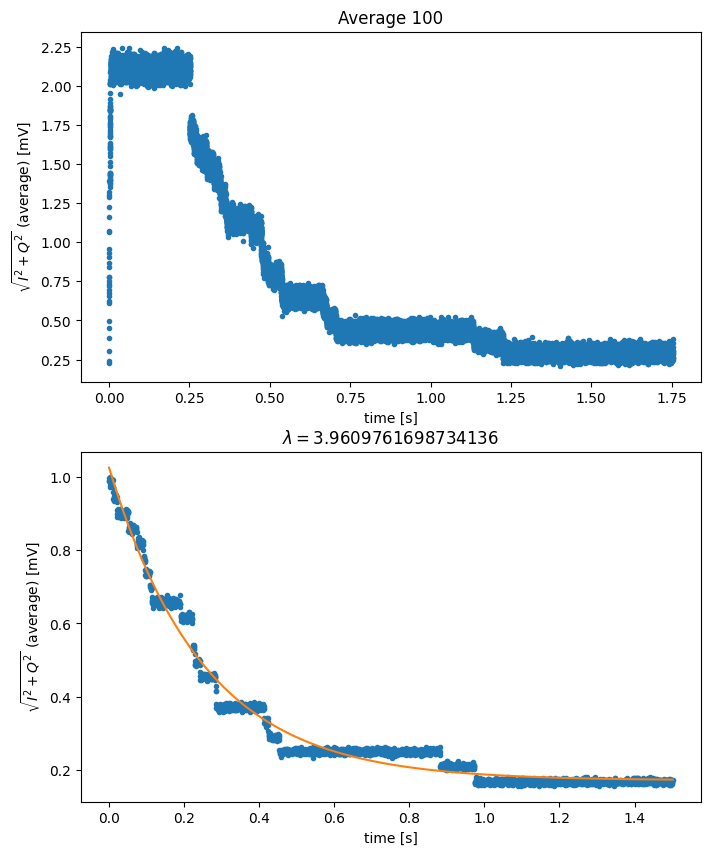

In [98]:
%matplotlib inline
number_avg=10
Processed_Data=an.Extract_vac_exc_gap(Data,amp_factor_array,freqs_array,Pump_Delay,number_avg)

amp_factor=amp_factor_array[0]
freqs=freqs_array[0,:]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]

        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3,".")
        #ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("$\lambda= $"+str(gap))
        ax.plot(time_fit,av_fit,".")
        ax.plot(time_fit,y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")



    else:
        print("No fit")
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        
        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(8,10),dpi=100)

        #Plotting the measurement 
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3)
        #ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

        ax=axs[1]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time_fit,av_fit)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

## Saving for a single frequency

In [11]:
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="excit_to_vac" #second folder 
name="Single_freq" # third folder 
meastype="test" #Final file name 

datadict={}
#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

#Saving of parameters 
datadict["n_empty"]=n_empty
datadict["n_repetition"]=n_repetition
datadict["n_full"]=n_full
datadict["amp_factor_array"]=amp_factor_array
datadict["amp_factor_array_high"]=amp_factor_high_array
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time"]=cooldown_time

#Saving of data 
datadict["freqs_array"]=freqs_array 
datadict["Data"]=Data
datadict["config"]=config

In [12]:
an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving in new directory


In [14]:
#loading the data 
filepath=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\excit_to_vac\Single_freq\test.npz"

npzfile=np.load(filepath,allow_pickle=True)
npzfile["multidata"][()]
freqs_array=npzfile["multidata"][()]["freqs_array"]
Data=npzfile["multidata"][()]["Data"]
amp_factor_array=npzfile["multidata"][()]["amp_factor_array"]
Pump_Delay=npzfile["multidata"][()]["Pump_Delay"]

# Multiple frequencies of single measurement with dual demodualtion 

In [69]:
#Select the frequencies 

span=1.3 * u.MHz # Span of the pumping 
df = 0.1* u.MHz # Step of the pumping 0.01
IF_center=0.1954e9 

freqs_array = np.array([np.arange(IF_center-span/2, IF_center+span/2, df)]) #sets of frequencies


fmin=0.1956e9
fmax=0.1958e9
df=0.01* u.MHz
freqs_array=np.array([np.arange(fmin, fmax+df/2, df)])

freqs=freqs_array[0,:] #select the first row 

freqs

array([1.9560e+08, 1.9561e+08, 1.9562e+08, 1.9563e+08, 1.9564e+08,
       1.9565e+08, 1.9566e+08, 1.9567e+08, 1.9568e+08, 1.9569e+08,
       1.9570e+08, 1.9571e+08, 1.9572e+08, 1.9573e+08, 1.9574e+08,
       1.9575e+08, 1.9576e+08, 1.9577e+08, 1.9578e+08, 1.9579e+08,
       1.9580e+08])

In [70]:
%matplotlib qt
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor_array=np.array([0.3]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

amp_factor_high_array=np.array([1.9]) #Prefactor of the amplitude 
amp_factor_high=amp_factor_high_array[0]

n_repetition=25 #number of repetitions 

n_empty=10_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=30_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=1_000_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  


save_Data=True
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="excit_to_vac" #second folder 
name="Multiple_freq" # third folder 
meastype="0p3_amp_test" #Final file name 


print("The different frequency {}".format(freqs))
Expected_time=(Readout_Len*n_runs*1e-9*n_repetition+n_repetition*(cooldown_time*4*1e-9+Pump_Delay*4*1e-9))/60*len(freqs)
print("The expected time : {} min".format(Expected_time))

The different frequency [1.9560e+08 1.9561e+08 1.9562e+08 1.9563e+08 1.9564e+08 1.9565e+08
 1.9566e+08 1.9567e+08 1.9568e+08 1.9569e+08 1.9570e+08 1.9571e+08
 1.9572e+08 1.9573e+08 1.9574e+08 1.9575e+08 1.9576e+08 1.9577e+08
 1.9578e+08 1.9579e+08 1.9580e+08]
The expected time : 30.65125 min


In [71]:
%%time


Data={} #dictionnary to hold all the data 
Data[amp_factor]={}
for idx,IF_pump in enumerate(freqs) :
    
    print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))

    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 
    
    av, time=First_jump_single_freq(Readout_Len, amp_factor, amp_factor_high, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm)
    plt.close()
    
    Data[amp_factor][IF_pump]={}
    Data[amp_factor][IF_pump]["value"]=av
    Data[amp_factor][IF_pump]["time"]=time
    
    
if save_Data:
    
    datadict={}
    datadict["LO_fluxline"]=LO_fluxline
    datadict["IF_fluxline"]=IF_pump
    datadict["IF_readout"]=IF_resonator
    datadict["LO_readout"]=LO_readout


    datadict["n_empty"]=n_empty
    datadict["n_repetition"]=n_repetition
    datadict["n_full"]=n_full
    datadict["amp_factor_array"]=amp_factor_array
    datadict["amp_factor_array_high"]=amp_factor_high_array
    datadict["Offset_IF"]=Offset_IF
    datadict["Readout_Len"]=Readout_Len
    datadict["Pump_Delay"]=Pump_Delay
    datadict["cooldown_time"]=cooldown_time
    datadict["Data"]=Data
    datadict["freqs_array"]=freqs_array
    datadict["config"]=config
    
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

########################### Frequency 8695600000.0########################### 0.0
2023-04-24 12:23:13,021 - qm - INFO - Flags: 
2023-04-24 12:23:13,022 - qm - INFO - Sending program to QOP
2023-04-24 12:23:13,470 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8695610000.0########################### 0.047619047619047616
2023-04-24 12:24:30,065 - qm - INFO - Flags: 
2023-04-24 12:24:30,066 - qm - INFO - Sending program to QOP
2023-04-24 12:24:30,534 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8695620000.0########################### 0.09523809523809523
2023-04-24 12:25:47,369 - qm - INFO - Flags: 
2023-04-24 12:25:47,369 - qm - INFO - Sending program to QOP
2023-04-24 12:25:48,213 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8695630000.0########################### 0.14285714285714285
2023-04-24 12:27:04,372 - qm - INFO - Flags: 
2023-04

## Saving for multiple frequencies 

In [23]:
#Saving the data 
cooldown_date=Cooldown_Date #top folder 
device="excit_to_vac" #second folder 
name="Multiple_freq" # third folder 
meastype="test" #Final file name 

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout


datadict["n_empty"]=n_empty
datadict["n_repetition"]=n_repetition
datadict["n_full"]=n_full
datadict["amp_factor_array"]=amp_factor_array
datadict["amp_factor_array_high"]=amp_factor_high_array
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time"]=cooldown_time
datadict["Data"]=Data
datadict["config"]=config
datadict["freqs_array"]=freqs_array

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving in new directory


In [101]:
#Loading the data 

filepath= r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\excit_to_vac\Multiple_freq\0p3_amp_test.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

Pump_Delay=npzfile["multidata"][()]["Pump_Delay"]
Data=npzfile["multidata"][()]["Data"]
freqs_array=npzfile["multidata"][()]["freqs_array"]
amp_factor_array=npzfile["multidata"][()]["amp_factor_array"]
amp_factor_array_high=npzfile["multidata"][()]["amp_factor_array_high"]

## Plotting for multiple frequencies 

In [113]:
%matplotlib qt
#Plot all 
number_avg=10
Processed_Data=an.Extract_vac_exc_gap(Data,amp_factor_array,freqs_array,Pump_Delay,number_avg)
amp_factor=amp_factor_array[0]
freqs=freqs_array[0,:]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        
        
        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(5,10),dpi=100)
        
        av=Data[amp_factor][freqs[idx]]["value"]
        time=Data[amp_factor][freqs[idx]]["time"]
        
        ax=axs[0]
        ax.set_title("Average "+str(n_repetition))
        ax.plot(time*1e-9,av*1e3,".")
        #ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(av*1e3)],"r")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")
        
        ax=axs[1]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx)+" $\lambda= $"+str(round(gap,2)))
        ax.plot(time_fit,av_fit)
        ax.plot(time_fit,y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")



    else:
        print("No fit")
        time_fit=Processed_Data[amp_factor][freqs[idx]]["time_fit"]
        av_fit=Processed_Data[amp_factor][freqs[idx]]["av_fit"]
        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time_fit,av_fit)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("$\sqrt{I^2 + Q^2}$ (average) [mV]")

No fit


## Extracting the Liouvillian gap 

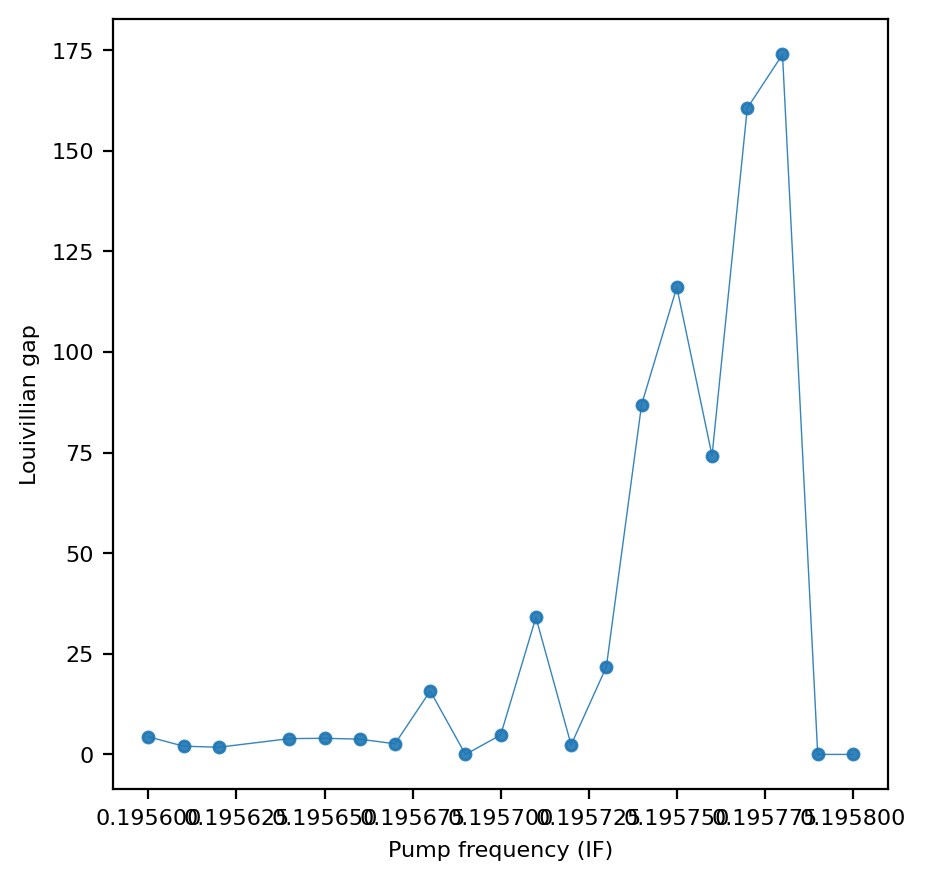

In [73]:
%matplotlib inline


amp_factor=amp_factor_array[0]
freqs=freqs_array[0,:]

gap_array=[]
freq_gap_array=[]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:
        gap_array.append(Processed_Data[amp_factor][freqs[idx]]["gap"])
        freq_gap_array.append(freqs[idx])
        
gap_array=np.array(gap_array)
freq_gap_array=np.array(freq_gap_array)
        
        

# figsize=(5,4)

fontsize=8
figsize=(5,4)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=200)

axs.plot(freq_gap_array/1e9,gap_array,'.-',alpha=.9, lw=.5, ms=8)
axs.set_xlabel("Pump frequency (IF)",fontsize=fontsize)
axs.set_ylabel("Louivillian gap",fontsize=fontsize)
axs.tick_params(axis='x', labelsize=fontsize)
axs.tick_params(axis='y', labelsize=fontsize)

# Test

In [71]:
%matplotlib qt

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)


amp_factor_array=np.array([0.6]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

amp_factor_high_array=np.array([1]) #Prefactor of the amplitude 
amp_factor_high=amp_factor_high_array[0]


#Update the pump IF frequency 
freqs_array=np.array([[ 0.19565e9]]) # defines the IF of the pump  
IF_pump=freqs_array[0,0]
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=20 #number of repetitions 

n_empty=5_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=30_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=5_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  


with program() as IQ_blobs:

    n = declare(int)
    n_rep = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)
    n_rep_st=declare_stream()

    assign_variables_to_element("resonator", I,Q) 

    #Update the demodulation frequency 
    update_frequency("resonator",IF_resonator+Offset_IF) 
    update_frequency("fluxline",IF_pump)
    
    #Loop on the repetition 
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):

        #Loop on the repetition 
        with for_(i, 0, i < np.round((n_empty*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor_high), 'fluxline')  

        with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor), 'fluxline')  



        #Demodulation measurements 
        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate n time 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)

        save(n_rep, n_rep_st)

        wait(cooldown_time) #wait the cooldown 

    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")
        n_rep_st.save("n_rep")



simulation = False     

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )

    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

else:

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")

    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

    while results.is_processing():
        I, Q, n_rep = results.fetch_all()

        #dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        time=I["timestamp"]
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse Readout_lEN 
        Q = u.demod2volts(Q["value"], Readout_Len)

        plt.subplot(211)
        plt.cla()
        fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        plt.plot(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        #plt.plot(I**2+Q**2,".",markersize=2)
        plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)




2023-04-21 18:02:13,192 - qm - INFO - Flags: 
2023-04-21 18:02:13,193 - qm - INFO - Sending program to QOP
2023-04-21 18:02:13,748 - qm - INFO - Executing program
Execution stopped by user!


In [59]:
I_2d=I.reshape((n_repetition,n_runs))
Q_2d=Q.reshape((n_repetition,n_runs))
time_2d=time.reshape((n_repetition,n_runs))

norm_2d=np.sqrt(I_2d**2+Q_2d**2)
#We reset the timer to zero for each idx
time_2d=(time_2d.transpose()-time_2d[:,0]).transpose()


Text(0, 0.5, "r'$I^2 + Q^2$ (average) [V]")

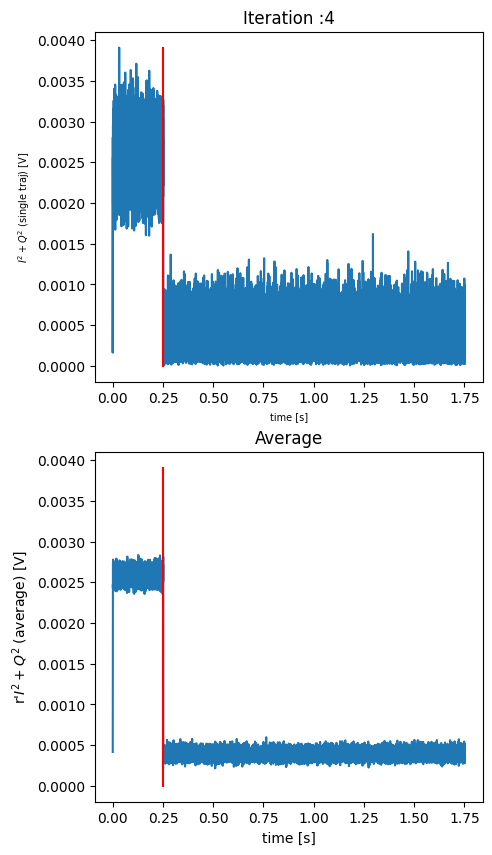

In [60]:
%matplotlib inline
idx=4
fontsize=7
fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(5,10),dpi=100)

ax=axs[0]
ax.set_title("Iteration :" + str(idx))
ax.plot(time_2d[idx,:]*1e-9,norm_2d[idx,:])
ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(norm_2d[idx,:])],"r")
ax.set_ylabel(r'$I^2 + Q^2$ (single traj) [V]',fontsize=fontsize)
ax.set_xlabel("time [s]",fontsize=fontsize)
#average over all axis :
ax=axs[1]
ax.set_title("Average")
av=np.mean(norm_2d,axis=0)
ax.plot(time_2d[0,:]*1e-9,av)
ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(norm_2d[idx,:])],"r")
ax.set_xlabel("time [s]")
ax.set_ylabel("r'$I^2 + Q^2$ (average) [V]")
